In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from dataclasses import dataclass
from typing import List
from keras import layers, ops
from keras.utils import timeseries_dataset_from_array
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [143]:
csv_data = pd.read_csv("data/YF_IBM.csv")
data = csv_data.loc[:, ["Date", "Adj Close"]]
orig_data = data.copy()

In [108]:
def split_indices(data, train_size, val_size):
    train_idx = int(train_size * data.shape[0])
    val_idx = int((train_size + val_size) * data.shape[0])
    return train_idx, val_idx

In [109]:
def make_stationary(data):
    diffed = data.copy()
    diffed = data.diff()
    return diffed

def inverse_stationary(original, yhat):
    return yhat.to_numpy() + original.loc[:-1].to_numpy()

In [110]:
def scale(data, avail_idx, scaler):
    scaler.fit(data[:avail_idx])
    return scaler.transform(data)

def unscale(data, scaler):
    return scaler.inverse_transform(data)

In [111]:
train_size = 0.7
val_size = 0.15
train_idx, val_idx = split_indices(data, train_size, val_size)

data.loc[:, "Adj Close"] = make_stationary(data["Adj Close"])
data = data.dropna()
scaler = MinMaxScaler((-1, 1))
data["Adj Close"] = scale(data["Adj Close"].to_numpy().reshape((-1, 1)), val_idx, scaler=scaler)
data

,Date,Adj Close
1,2000-01-04,-0.062858
2,2000-01-05,0.327201
3,2000-01-06,0.033109
4,2000-01-07,0.107409
5,2000-01-10,0.355060
...,...,...
6159,2024-06-27,0.034301
6160,2024-06-28,0.333670
6161,2024-07-01,0.338470
6162,2024-07-02,0.343266


In [112]:
def sequence(data, seq_len, batch_sz, shuffle=True):
    x = data[:-seq_len].to_numpy(dtype=np.float32).reshape((-1, 1))
    y = data[seq_len:].to_numpy(dtype=np.float32).reshape((-1, 1))
    ds = timeseries_dataset_from_array(
        x, 
        y, 
        sequence_length=seq_len,
        batch_size=batch_sz,
        shuffle=shuffle
    )
    return ds

In [113]:
seq_len = 20
batch_sz = 16
drop_remain = True

train_ds = sequence(data["Adj Close"][:train_idx], seq_len, batch_sz)
val_ds = sequence(data["Adj Close"][train_idx+1:val_idx], seq_len, batch_sz, shuffle=False)

In [114]:
for batch in train_ds.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (16, 20, 1)
Target shape: (16, 1)


2024-07-31 10:03:31.677391: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [115]:
@dataclass
class LSTMLayerHyperparams:
    units: int
    activation: str = "relu"
    recurrent_activation: str = "relu"
    kernel_initializer: str = "glorot_uniform"
    recurrent_initializer: str = "orthogonal"
    bias_initializer: str = "zeros"
    dropout: float = 0.0
    recurrent_dropout: float = 0.0
    return_sequences: bool = False
    return_state: bool = False
    stateful: bool = False

@dataclass
class ModelHyperparams:
    lstm_layers: List[LSTMLayerHyperparams]

In [116]:
def get_model(batch_size, optimizer, loss, metrics, hparams: ModelHyperparams, seperate_output_layer=True):
    model = keras.Sequential()    
    model.add(keras.Input(
        shape=(20, 1),
        batch_size=batch_size,
        name="Inputs"
    ))
    for idx, l in enumerate(hparams.lstm_layers):
        model.add(layers.LSTM(
            l.units,
            activation=l.activation,
            recurrent_activation=l.recurrent_activation,
            kernel_initializer=l.kernel_initializer,
            recurrent_initializer=l.recurrent_initializer,
            bias_initializer=l.bias_initializer,
            dropout=l.dropout,
            recurrent_dropout=l.recurrent_dropout,
            return_sequences=l.return_sequences,
            return_state=l.return_state,
            stateful=l.stateful,
        ))
    if seperate_output_layer:
        model.add(layers.Dense(1))
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [117]:
lstm_params = LSTMLayerHyperparams(100)
hparams = ModelHyperparams([lstm_params])
opt= keras.optimizers.Adam(learning_rate=0.001)

model = get_model(32, opt, "mse", ["mse"], hparams)

es_cb = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10)

history = model.fit(
    train_ds,
    epochs=500,
    validation_data=val_ds,
    callbacks=[es_cb]
)

Epoch 1/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0175 - mse: 0.0175 - val_loss: 0.0268 - val_mse: 0.0268
Epoch 2/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0270 - val_mse: 0.0270
Epoch 3/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0265 - val_mse: 0.0265
Epoch 4/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0265 - val_mse: 0.0265
Epoch 5/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0267 - val_mse: 0.0267
Epoch 6/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0266 - val_mse: 0.0266
Epoch 7/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0267 - val_mse: 0.0267
Epoch 8/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0267 - val_mse: 0.0267
Epoch 9/500
268/268 ━━━━━━━━━━━━━━━━━━━━

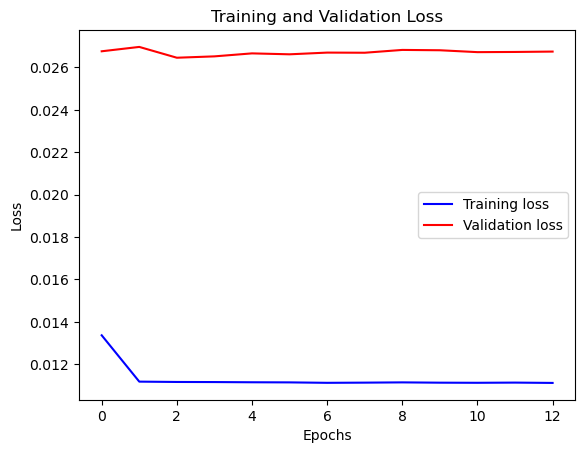

In [118]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


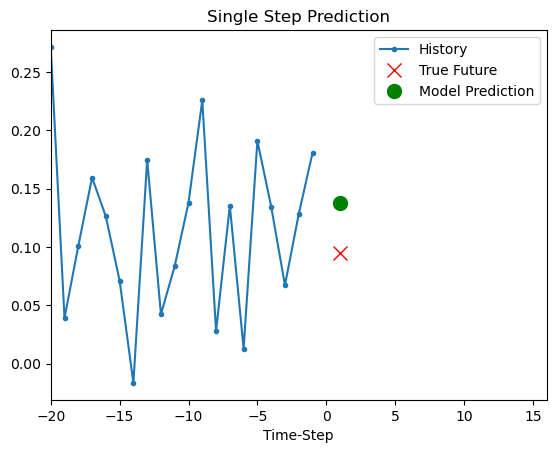

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


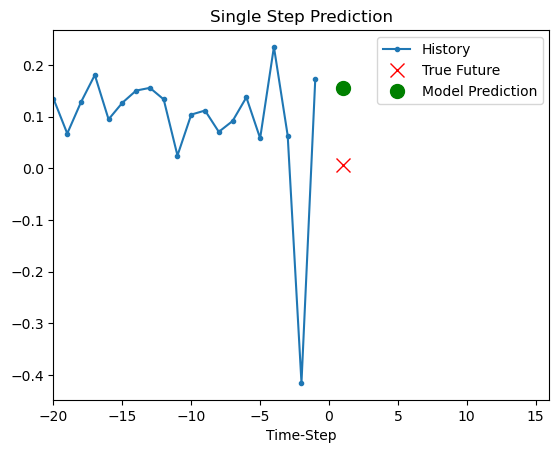

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


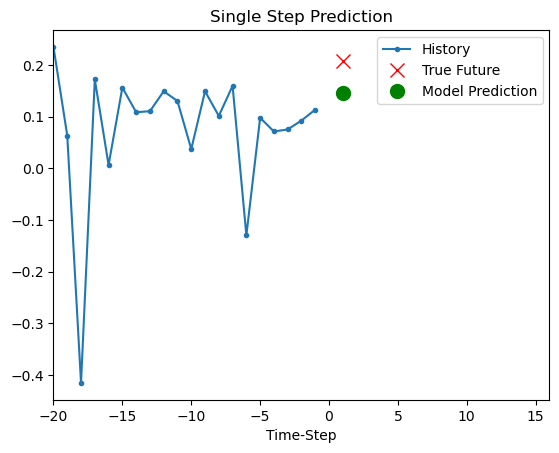

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


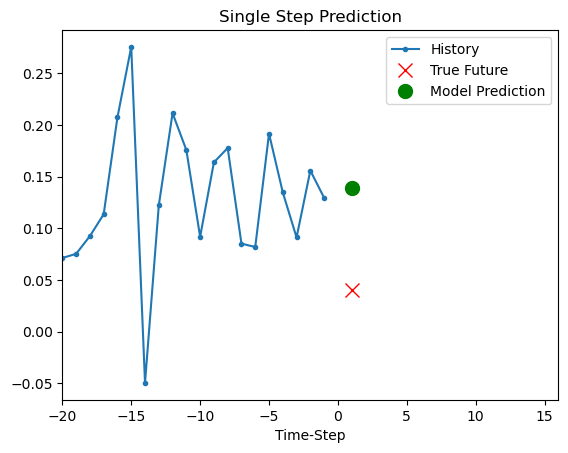

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


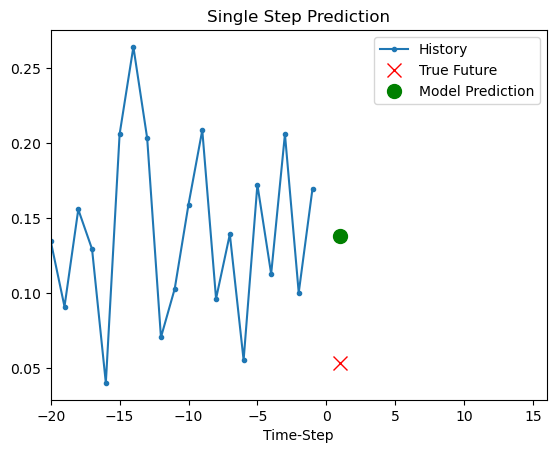

2024-07-31 10:04:21.514584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [119]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-20, 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 15)])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in val_ds.take(5):
    show_plot(
        [x[0].numpy(), y[0].numpy(), model.predict(x)[0]],
        1,
        "Single Step Prediction",
    )
#    print(x[0])
#    break

In [120]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-20, 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 15)])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in val_ds.take(5):
    show_plot(
        [inverse_stationary(unscale(x[0].numpy().reshape(-1, 1), scaler)), inverse_stationary(unscale(y[0].numpy().reshape(-1, 1), scaler)), inverse_stationary(unscale(model.predict(x)[0].reshape(-1, 1), scaler))],
        1,
        "Single Step Prediction",
    )
#    print(x[0])
#    break

TypeError: inverse_stationary() missing 1 required positional argument: 'yhat'

In [153]:
val_array = list(iter(val_ds.unbatch()))
unprocessed = sequence(orig_data["Adj Close"][train_idx+1:val_idx], seq_len, batch_sz, shuffle=False).unbatch()
unp_arr = list(iter(unprocessed))
len(val_array)
len(unp_arr)

2024-07-31 11:40:08.810906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-31 11:40:09.326905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


885

In [156]:
def make_prediction(sequence, model):
    x = make_stationary(sequence)
    x = scale(sequence, scaler)
    raw_pred = model.predict(x)
    pred = unscale(raw_pred, scaler)
    pred = sequence[-1] + pred
    return pred

In [164]:
unp_arr[1][0].numpy().flatten()
#make_prediction(unp_arr[0][0])

array([124.14649 , 123.17757 , 122.850075, 123.136635, 123.07523 ,
       122.44071 , 120.891846, 121.33533 , 120.40059 , 119.89566 ,
       119.957115, 120.93277 , 119.84789 , 119.882034, 118.64023 ,
       119.25428 , 119.28157 , 118.606125, 118.56515 , 119.07011 ],
      dtype=float32)